In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler


# select device: change to 'cpu' if there's no GPU device
device = torch.device('cuda:1')

In [2]:
import pickle as pkl

Rho = pkl.load( open("./CorrelationRho.pkl","rb"))

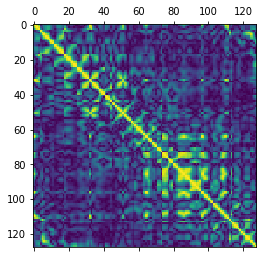

In [3]:
plt.matshow(np.abs(Rho))

In [4]:
V = Rho.shape[0]

In [5]:
Ltri = np.tril_indices(V,-1)

In [6]:
LtriTorch = torch.tril(torch.ones(V, V),diagonal=-1) == 1

In [7]:
UtriTorch = torch.triu(torch.ones(V, V),diagonal=1) == 1

In [8]:
RhoVec = Rho[Ltri]

In [9]:
RhoVecTorch = torch.tensor(RhoVec, device=device, dtype=torch.float32)

In [10]:
phi0 = torch.randn(V,device=device, dtype=torch.float32).requires_grad_()


In [11]:
phi = torch.softmax(phi0,0)

In [12]:
# invertible neural network
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask):
        super(RealNVP, self).__init__()
        
        self.mask = nn.Parameter(mask, requires_grad=False).to(device)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def f(self, z):
        x = z
        log_det_J = z.new_zeros(z.shape[0])
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.sign(s) * torch.exp(s) + t)

            log_det_J += s.sum(dim=1)

        return x, log_det_J

In [13]:
def diffRound(x,t=2):
    x_ = torch.floor(x)
    return x_ + torch.sigmoid( 10**t * (x - x_ -0.5))

In [14]:
# number of mixture components
K = 2

In [15]:
latent_d = 256

In [16]:
p = int(V*(V-1)/2) + V

In [17]:
p

8256

In [18]:
total_param = p

mask1 = [0,1]* int(total_param/2)
mask2 = [1- x for x in mask1]


nets = lambda: nn.Sequential(nn.Linear(p, latent_d), nn.LeakyReLU(), nn.Linear(latent_d, latent_d), 
                             nn.LeakyReLU(), nn.Linear(latent_d, p), nn.Tanh()).to(device)
nett = lambda: nn.Sequential(nn.Linear(p, latent_d), nn.LeakyReLU(), nn.Linear(latent_d, latent_d),
                             nn.LeakyReLU(), nn.Linear(latent_d, p)).to(device)
masks = torch.from_numpy(np.array([mask1, mask2] * 4).astype(np.float32)).cuda(1)

flow_list = [RealNVP(nets, nett, masks) for _ in range(K)]

net_pi = lambda: nn.Sequential(nn.Linear(p, latent_d), nn.LeakyReLU(), nn.Linear(latent_d, latent_d), 
                               nn.LeakyReLU(), nn.Linear(latent_d, K), nn.Softmax(dim=1)).to(device)

flow_pi = net_pi()

In [19]:
# n: training batch size

n = 1000

In [20]:
# the target log-prior-likelihood

class Loglik(nn.Module):
    def __init__(self):
        super(Loglik, self).__init__()

    def setP(self, Rho):
        self.logp = torch.log(Rho)
        self.log1p = torch.log(1.0-Rho)
        
    def f(self, z):
    
        loglik = self.logp* z + self.log1p*(1.0 -z)
        return  loglik.sum(1)


compLoglik = Loglik()
compLoglik.setP(RhoVecTorch.abs())

def logReferenceDensity(z):
    return 0

In [21]:
def deri_sigmoid(x):
    return -x - 2* torch.nn.Softplus()(-x)

In [22]:
para_list = list()

In [23]:
for flow in flow_list:
    para_list+= list(flow.parameters())
    
para_list +=  list(flow_pi.parameters())

In [24]:
import copy


best_loss = np.inf

Optimize to learn the random transport, as a mixture of K maps

In [25]:
optimizer = torch.optim.Adam([p for p in para_list if p.requires_grad==True], lr=1e-4)

In [26]:
def softplus(x):
    return torch.nn.Softplus()(x)

In [27]:
def deriSoftplus(x):
    return x - softplus(x)

In [28]:
for t in range(3000):
    
    
    x = torch.rand([n,p]).to(device)
        
    Loglik_list = list()
    z_list = list()
    
    log_pis = torch.log(flow_pi(x))
    
    for k in range(K):
        flow = flow_list[k]
        z_cad, logdetJ = flow.f(x)


        z_A = z_cad[:, :int(V*(V-1)/2)]

        z_Phi = z_cad[:, int(V*(V-1)/2):]
        
        eta =  torch.sigmoid(z_A)

        
        theta = diffRound(eta)


        Phi = torch.nn.Softplus()(z_Phi)
        
        
        # penalize row sum
        A = torch.ones([n,V,V], device=device)

        A[:,LtriTorch] = theta
        torch.transpose(A,1,2)[:,LtriTorch] = theta
        # eiAgenvaluesalpha
#             _,evA,_ = torch.svd(A)
        # row sum
        Asum = A.sum(1) -1 

        
        Phi = torch.nn.Softplus()(z_Phi)
        Phi = Phi / Phi.sum(1, keepdim=True)

        tau = 128

        laplace_prior =  (- torch.abs(Asum) / Phi/tau -  torch.log(Phi)).sum(1)
        
        alpha = 0.001
        dirichlet_prior = (alpha-1) * torch.log(Phi).sum(1)
        
        total = compLoglik.f(theta) + logdetJ + \
            deri_sigmoid(z_A).sum(1) + deriSoftplus(z_Phi).sum(1) +\
            dirichlet_prior + laplace_prior + \
            torch.log(flow_pi(z_cad)[:,k])
            
        Loglik_list.append(total)
        
    total_loglik = torch.logsumexp(torch.stack(Loglik_list), dim=0) - logReferenceDensity(x)

    loss =  - total_loglik.mean()

    
    if t%100==0:
        print(t, loss.item())
        
        
    if torch.isnan(loss).any() or torch.isinf(loss):
        [flow_list , flow_pi] = copy.deepcopy(best_model)
    else:    
        if loss.item()< best_loss:
            best_model= copy.deepcopy([flow_list , flow_pi])
            best_loss = loss.item()    

    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward(retain_graph=True)

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()

0 29536.384765625
100 11774.978515625
200 10173.791015625
300 9920.279296875
400 9780.9423828125
500 9742.6591796875
600 9533.4521484375
700 9330.1328125
800 9247.34765625
900 9076.9091796875
1000 8917.896484375
1100 8777.4423828125
1200 8737.078125
1300 8638.552734375
1400 8642.296875
1500 8663.412109375
1600 8625.734375
1700 8610.8779296875
1800 8615.65625
1900 8613.7080078125
2000 8577.3662109375
2100 8591.4921875
2200 8567.134765625
2300 8566.2705078125
2400 8537.166015625
2500 8542.9580078125
2600 8536.4404296875
2700 8544.3037109375
2800 8517.2197265625
2900 8506.6025390625


In [29]:
def getNp(x):
    return x.detach().cpu().numpy()

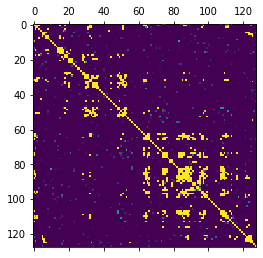

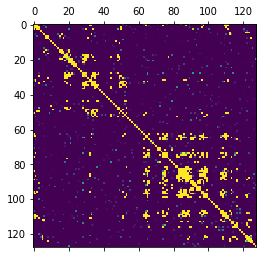

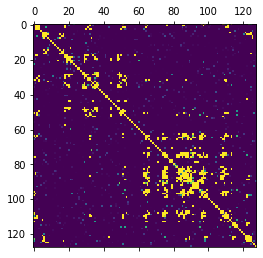

In [30]:
# plot three random samples of A
plt.matshow(getNp(A)[0])
plt.matshow(getNp(A)[1])
plt.matshow(getNp(A)[2])

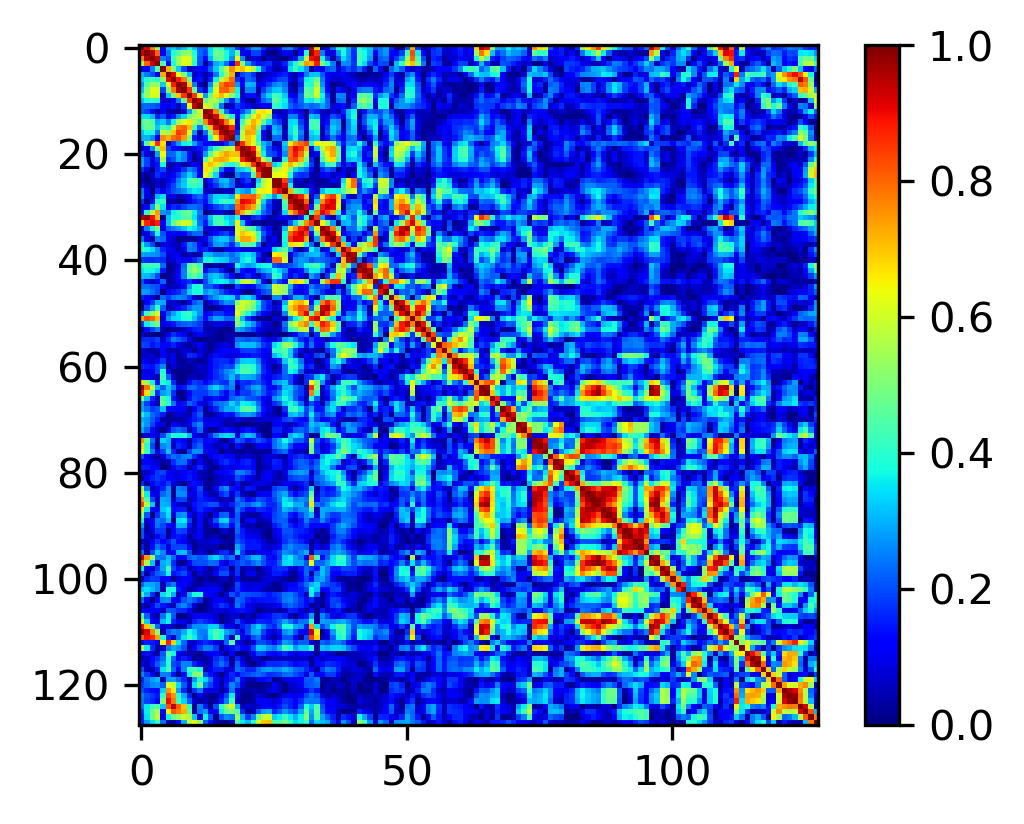

In [31]:
fig = plt.figure(dpi=300,figsize=(4, 3))



plt.imshow(np.abs(Rho), vmin=0,vmax= 1,cmap='jet')
plt.colorbar()


fig.savefig('network_corr.png')

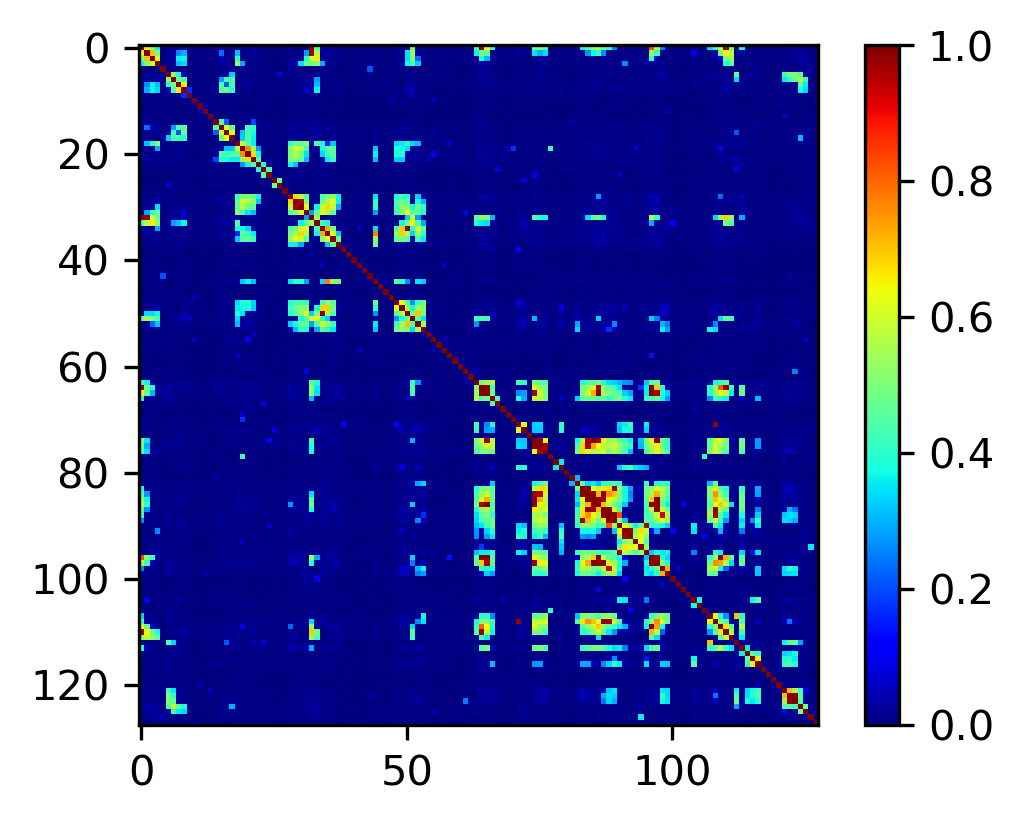

In [32]:
fig = plt.figure(dpi=300,figsize=(4, 3))

plt.imshow(np.abs(getNp(A.mean(0))), vmin=0,vmax= 1,cmap='jet')
plt.colorbar()


fig.savefig('network_est_model.png')

In [33]:
from sklearn.covariance import graphical_lasso

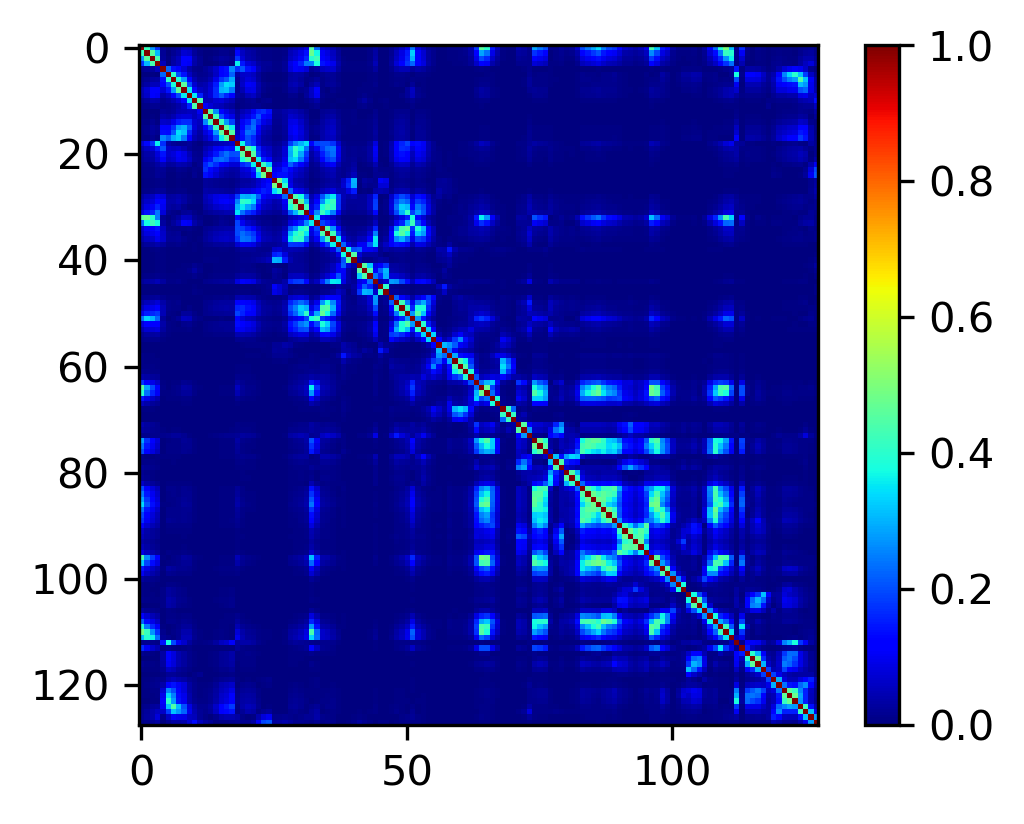

In [34]:
glasso = graphical_lasso(Rho, alpha= .5)

glasso[0]

fig = plt.figure(dpi=300,figsize=(4, 3))

plt.imshow( np.abs(glasso[0]), vmin=0,vmax= 1,cmap='jet')
plt.colorbar()


fig.savefig('network_corr_glasso.png')

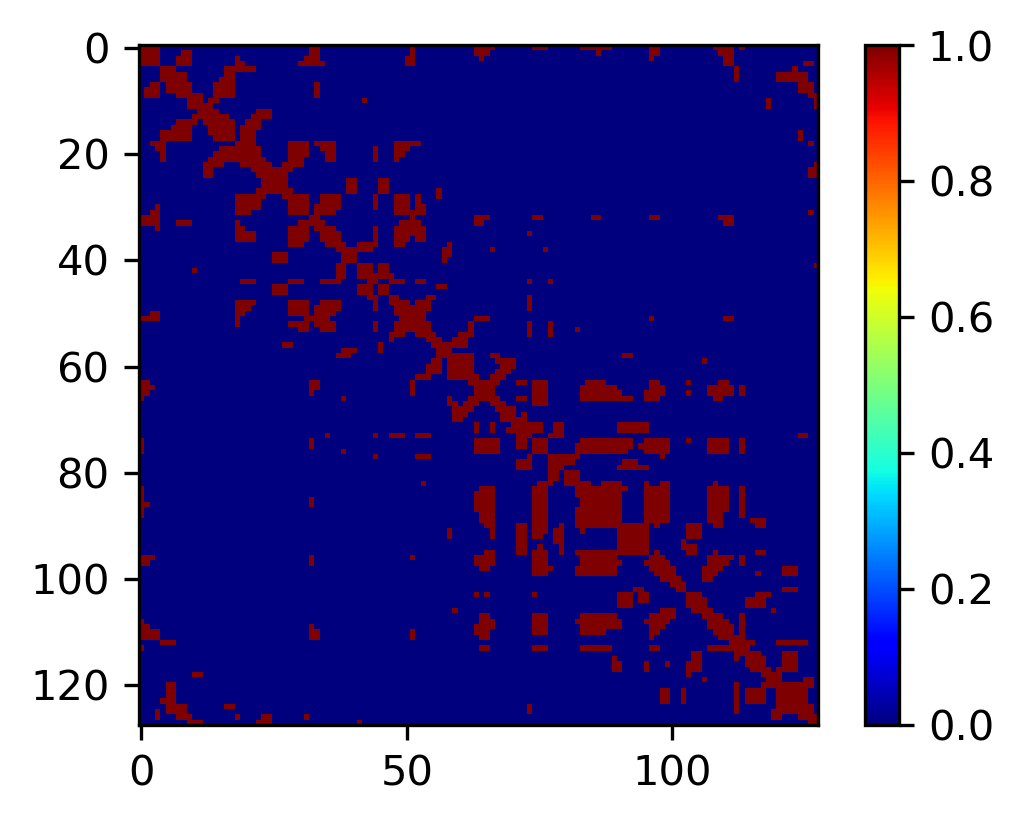

In [35]:
fig = plt.figure(dpi=300,figsize=(4, 3))

plt.imshow( (np.abs(Rho)>0.5), vmin=0,vmax= 1,cmap='jet')
plt.colorbar()


fig.savefig('network_corr_threshold.png')

In [36]:
phi_np = getNp(Phi)

In [37]:
Arow_np = getNp(A.sum(1))

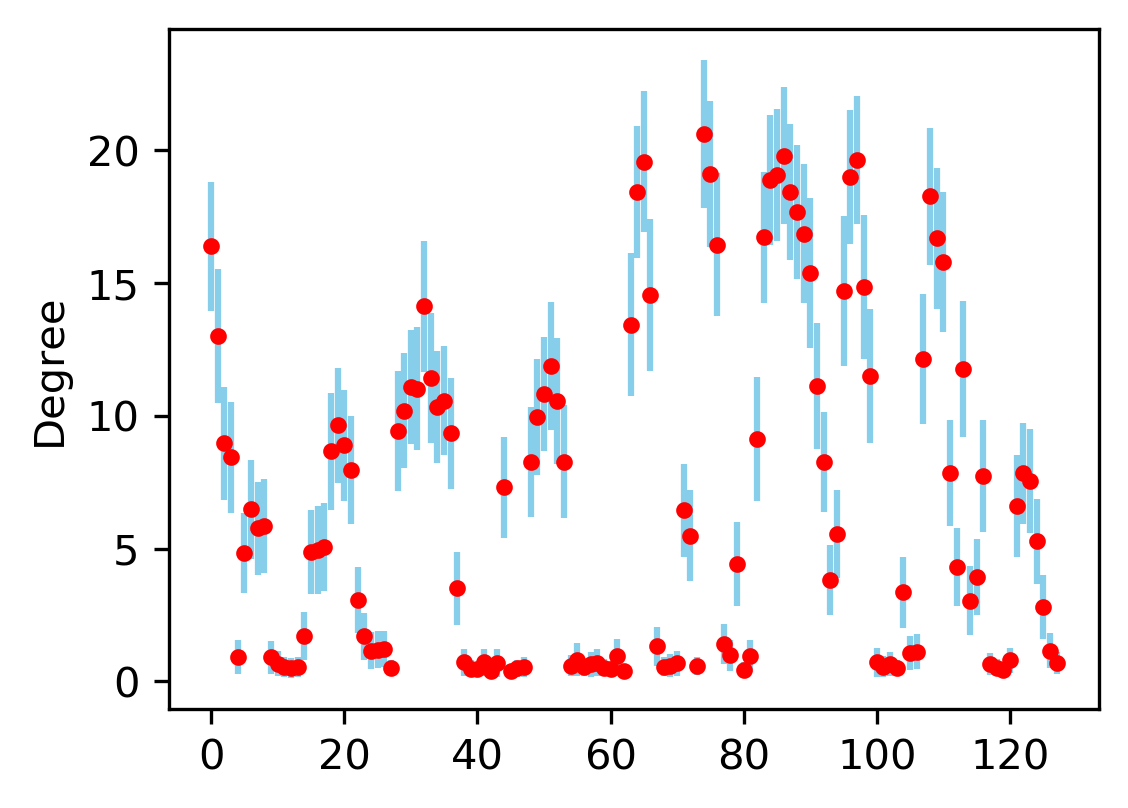

In [38]:
fig = plt.figure(dpi=300,figsize=(4, 3))

plt.errorbar(np.arange(128), Arow_np.mean(0)-1,yerr=np.std(Arow_np,axis=0),fmt='o', ecolor='skyblue', marker='') 
#              alpha=0.3,  uplims=True, lolims=True           ,linestyle='')
plt.plot(np.arange(128),Arow_np.mean(0)-1, marker='.',linestyle='',color='red')

plt.ylabel("Degree")


fig.savefig('network_shrinkage_degree.png')

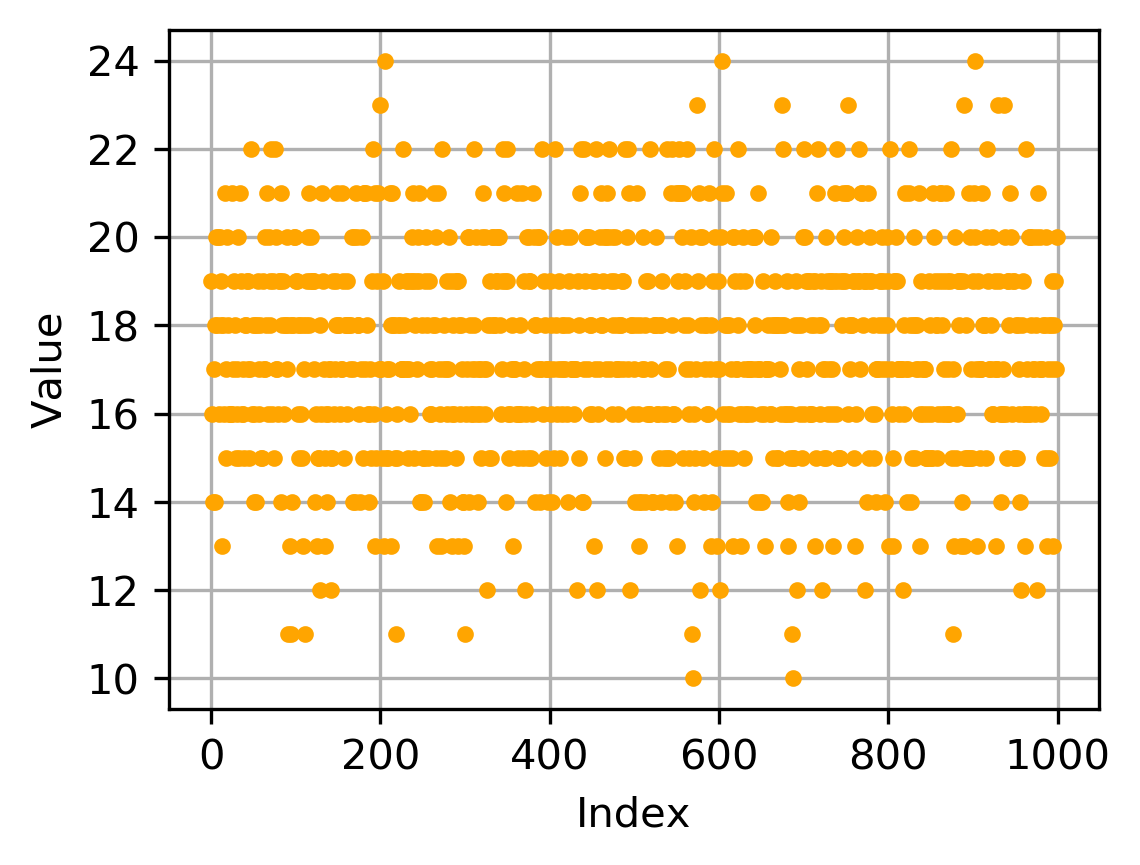

In [39]:
fig = plt.figure(dpi=300,figsize=(4, 3))

plt.grid(True, 'major')


plt.plot(np.round(Arow_np[:,0]),marker='.',linestyle='',c='orange')
plt.yticks(np.arange(10,25,step=2))

plt.ylabel("Value")
plt.xlabel("Index")

fig.savefig('network_degree_trace.png')